1. Split frmer big function to singles

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
import os


In [25]:
## Read all '.mat' data in one Subject
data_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/data/MMData'

'''Sub_combined_data_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/data/Sub_combined_data'
if not os.path.exists(Sub_combined_data_path):
    os.makedirs(Sub_combined_data_path)'''
    
## Dict Sub contains all subjects
Sub = {} 
Sub['sub_id'] = list(os.walk(data_root))[0][1] #len(Sub['sub_id']) = 15

def combine_all_subjects_row_data(i):
    Sub[f"{Sub['sub_id'][i]}"] = {}
    rest1_s = []
    CT_s = []
    recover_s = []
    rest2_s = []
    Sub[f"{Sub['sub_id'][i]}"]['seg'] = [n.split('.')[0] for n in list(os.walk(data_root))[i+1][2]]
    #print(Sub[f"{Sub['sub_id'][i]}"]['seg'])
    for s in Sub[f"{Sub['sub_id'][i]}"]['seg']:
        Sub[f"{Sub['sub_id'][i]}"][s] = scipy.io.loadmat(f"{data_root}/{Sub['sub_id'][i]}/{s}.mat")[s]
        for r in s.split('_'):
            if r in ['recover', 're', 'Recover']: #this seg is one of Recover
                recover_s.append(s)
            elif r in ['rest1']:
                rest1_s.append(s)
            elif r in ['CT', 'ct']:
                CT_s.append(s)
            elif r in ['rest2']:
                rest2_s.append(s)
            elif r in ['rest']:
                rest_index = s.split('_').index('rest')
                if s.split('_')[rest_index + 1] == '1':
                    rest1_s.append(s)
                else:
                    rest2_s.append(s)

    #print(rest1_s)
    ## Type 4 stage in one Subject
    Sub[f"{Sub['sub_id'][i]}"]['rest1'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in rest1_s], axis=1)
    r1code = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['rest1'].shape[1]), 1)
    Sub[f"{Sub['sub_id'][i]}"]['rest1'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest1'], r1code), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['CT'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in CT_s], axis=1)
    CTcode = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['CT'].shape[1]), 2)
    Sub[f"{Sub['sub_id'][i]}"]['CT'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['CT'], CTcode), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['recover'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in recover_s], axis=1)
    recode = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['recover'].shape[1]), 3)
    Sub[f"{Sub['sub_id'][i]}"]['recover'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['recover'], recode), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['rest2'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in rest2_s], axis=1)
    r2code = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['rest2'].shape[1]), 4)
    Sub[f"{Sub['sub_id'][i]}"]['rest2'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest2'], r2code), axis=0)
    ## Concat to on entire one
    Sub[f"{Sub['sub_id'][i]}"]['data'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest1'], Sub[f"{Sub['sub_id'][i]}"]['CT'], Sub[f"{Sub['sub_id'][i]}"]['recover'], Sub[f"{Sub['sub_id'][i]}"]['rest2']), axis=1)
    #print(len(Sub[f"{Sub['sub_id'][i]}"]['data'][0]))
    #print(Sub[f"{Sub['sub_id'][i]}"]['data'])
    '''sub_comb_filename = Sub_combined_data_path + f"/S{Sub['sub_id'][i]}_combined.csv"
    np.savetxt(sub_comb_filename, Sub[f"{Sub['sub_id'][i]}"]['data'], delimiter=',')'''
    
    return

## Get 5 signals and show
fs = 2000
tags = ['ECG', 'CBP', 'PPG', 'IPG', 'Temp', 'Stage', 'ECGf']
result_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/MMData'

def get_signals_show(i, figshow=0):
    for da in range(6):
        Sub[f"{Sub['sub_id'][i]}"][f"{tags[da]}"] = Sub[f"{Sub['sub_id'][i]}"]['data'][da]
    if figshow==1:
        begin_index, end_index = 0, 30000 #S1.shape[1]
        fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(18, 10), dpi=96)
        for sgn in range(5):
            axs[sgn].plot(Sub[f"{Sub['sub_id'][i]}"]['data'][sgn][begin_index:end_index])
            axs[sgn].set_title(f"{tags[sgn]}")
        fig.subplots_adjust(hspace=0.55)
        result_path = result_root + f"/S{Sub['sub_id'][i]}"
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
        plt.show()

    return

for i in range(len(Sub['sub_id'])):
    combine_all_subjects_row_data(i)
    get_signals_show(i)


In [ ]:
## Filter ECG and show
def filter_ecg_show(i, lowcut=10.0, highcut=50.0, order=4, figshow=0):
    ecg_signal = Sub[f"{Sub['sub_id'][i]}"]['ECG']
    '''lowcut = 10.0
    highcut = 50.0
    order = 4'''
    b,a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)
    Sub[f"{Sub['sub_id'][i]}"]['ECGf'] = ecg_filtered
    #print(f"filtered_ecg: {ecg_filtered}")
    if figshow==1 :
        begin_index, end_index = 0, 30000
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,4),dpi=96)
        axs[0].plot(ecg_signal[begin_index:end_index])
        #axs[0].legend()
        axs[0].set_title(f"S{Sub['sub_id'][i]}_Original ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec")
        axs[1].plot(ecg_filtered[begin_index:end_index])
        #axs[1].legend()
        axs[1].set_title(f"S{Sub['sub_id'][i]}_Filtered ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec")
        fig.subplots_adjust(hspace=0.55)
        result_path = result_root + f"/S{Sub['sub_id'][i]}"
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_Ori&Fil_ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
        plt.show()
    return

## Find peaks & Get Features
def find_peaks_get_features(i, r_height=0.5, beat=100, figshow=0, split_rate = 0.7):
    peak_window = 20 * fs # 20sec per detecting
    seg_index = list(range(0, len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']), peak_window))
    seg_index.append(len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']))
    #print(f"Seg_index: {seg_index}")

    r_peak_index = []
    for sr in range(len(seg_index) - 1): #len(seg_index) - 1
        ecg_peak_signal = Sub[f"{Sub['sub_id'][i]}"]['ECGf'][seg_index[sr]:seg_index[sr+1]]
        height = r_height * np.max(ecg_peak_signal)
        distance = 60 / beat * fs
        #prominence = 0.5 * (np.max(filtered_ecg) - np.min(filtered_ecg))
        r_peak_index_seg, r_peak_value_fil = signal.find_peaks(ecg_peak_signal, height=height, distance=distance)
        r_peak_index += list(r_peak_index_seg + seg_index[sr])
    print(f"R peak index: {len(r_peak_index)}, {r_peak_index}")
    
    sbp_index = []
    dbp_index = []
    max_ppg_index = []
    min_ppg_index = []
    high_ipg_index = []
    low_ipg_index = []
    for ri in range(len(r_peak_index)-1):
        cbp_seg = Sub[f"{Sub['sub_id'][i]}"]['CBP'][r_peak_index[ri]:r_peak_index[ri+1]]
        sbp_index.append(r_peak_index[ri] + np.argmax(cbp_seg))
        cbp_seg_half = Sub[f"{Sub['sub_id'][i]}"]['CBP'][r_peak_index[ri]:sbp_index[-1]]
        print(f"seg_begin_index:{r_peak_index[ri]}, sbp_index: {sbp_index[-1]}")
        dbp_index.append(r_peak_index[ri] + np.argmin(cbp_seg_half))
        ppg_seg = Sub[f"{Sub['sub_id'][i]}"]['PPG'][r_peak_index[ri]:r_peak_index[ri+1]]
        if np.argmax(ppg_seg) > np.argmax(ppg_seg):
            max_ppg_index.append(r_peak_index[ri] + np.argmax(ppg_seg))
            min_ppg_index.append(r_peak_index[ri] + np.argmin(ppg_seg))
        else:
            centre_index = int(len(ppg_seg) / 2)
            maxppgdis = abs(np.argmax(ppg_seg) - centre_index)
            minppgdis = abs(np.argmin(ppg_seg) - centre_index)
            if maxppgdis < minppgdis: # maxppg_index is right
                max_ppg_index.append(r_peak_index[ri] + np.argmax(ppg_seg))
                ppg_seg_half = Sub[f"{Sub['sub_id'][i]}"]['PPG'][r_peak_index[ri]:max_ppg_index[-1]]
                min_ppg_index.append(r_peak_index[ri] + np.argmin(ppg_seg_half))
            else: #minppg_index is right
                pmini = np.argmin(ppg_seg)
                rppg_seg = ppg_seg[pmini:]
                max_ppg_index.append(r_peak_index[ri] + pmini + np.argmax(rppg_seg))
                min_ppg_index.append(r_peak_index[ri] + pmini)
            
        ipg_seg = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[ri]:r_peak_index[ri+1]]
        low_ipg_index.append(r_peak_index[ri] + np.argmin(ipg_seg))
        ipg_seg_half = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[ri]:low_ipg_index[-1]]
        if len(ipg_seg_half) > 0:
            high_ipg_index.append(r_peak_index[ri] + np.argmax(ipg_seg_half))
        else:
            high_ipg_index.append(r_peak_index[ri])
    print(f"SBP index: {len(sbp_index)}, {sbp_index}\nDBP index: {len(dbp_index)}, {dbp_index}")
    print(f"Max PPG index: {len(max_ppg_index)}, {max_ppg_index}\nMin PPG index: {len(min_ppg_index)}, {min_ppg_index}")
    print(f"High IPG index: {len(high_ipg_index)}, {high_ipg_index}\nLow IPG index: {len(low_ipg_index)}, {low_ipg_index}")
    
    if figshow == 1:
        begin_index = 0
        end_index = len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']) #len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']) #10 * peak_window
        fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(18, 10), dpi=96)
        axs[0].plot(Sub[f"{Sub['sub_id'][i]}"]['ECGf'][begin_index:end_index])
        axs[0].scatter(r_peak_index, Sub[f"{Sub['sub_id'][i]}"]['ECGf'][r_peak_index], label='R peak')
        axs[0].set_title('ECG')
        axs[0].legend()

        axs[1].plot(Sub[f"{Sub['sub_id'][i]}"]['CBP'][begin_index:end_index])
        axs[1].scatter(sbp_index, Sub[f"{Sub['sub_id'][i]}"]['CBP'][sbp_index],label='SBP')
        axs[1].scatter(dbp_index, Sub[f"{Sub['sub_id'][i]}"]['CBP'][dbp_index],label='DBP')
        axs[1].set_title('CBP')
        axs[1].legend()

        axs[2].plot(Sub[f"{Sub['sub_id'][i]}"]['PPG'][begin_index:end_index])
        axs[2].scatter(max_ppg_index, Sub[f"{Sub['sub_id'][i]}"]['PPG'][max_ppg_index], label='Max PPG')
        axs[2].scatter(min_ppg_index, Sub[f"{Sub['sub_id'][i]}"]['PPG'][min_ppg_index], label='Min PPG')
        axs[2].set_title('PPG')
        axs[2].legend()

        axs[3].plot(Sub[f"{Sub['sub_id'][i]}"]['IPG'][begin_index:end_index])
        axs[3].scatter(high_ipg_index, Sub[f"{Sub['sub_id'][i]}"]['IPG'][high_ipg_index],label='High IPG')
        axs[3].scatter(low_ipg_index, Sub[f"{Sub['sub_id'][i]}"]['IPG'][low_ipg_index],label='Low IPG')
        axs[3].set_title('IPG')
        axs[3].legend()

        axs[4].plot(Sub[f"{Sub['sub_id'][i]}"]['Temp'][begin_index:end_index])
        axs[4].set_title('Temp')

        axs[5].plot(Sub[f"{Sub['sub_id'][i]}"]['Stage'][begin_index:end_index])
        axs[5].set_title('Stage')
        fig.subplots_adjust(hspace=0.55)
        result_path = result_root + f"/S{Sub['sub_id'][i]}"
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_{len(r_peak_index)}Keypoints_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
        plt.show()

    features = {}
    features['Stage'] = Sub[f"{Sub['sub_id'][i]}"]['Stage'][r_peak_index[:-1]]
    features['heart_rate'] = [(r_peak_index[rpi+1] - r_peak_index[rpi])/fs for rpi in range(len(r_peak_index)-1)]
    print(f"max HR:{max(features['heart_rate'])}, min HR:{min(features['heart_rate'])}, len HR:{len(features['heart_rate'])}")
    features['R_peak'] = Sub[f"{Sub['sub_id'][i]}"]['ECGf'][r_peak_index[:-1]]
    print(f"max R_peak:{max(features['R_peak'])}, min R_peak:{min(features['R_peak'])}, len R_peak:{len(features['R_peak'])}")
    features['PTT'] = [(max_ppg_index[mpi] - r_peak_index[mpi]) / fs for mpi in range(len(max_ppg_index))]
    print(f"max PTT:{max(features['PTT'])}, min PTT:{min(features['PTT'])}, len PTT:{len(features['PTT'])}")
    features['Max_PPG'] = Sub[f"{Sub['sub_id'][i]}"]['PPG'][max_ppg_index]
    print(f"max Max_PPG:{max(features['Max_PPG'])}, min Max_PPG:{min(features['Max_PPG'])}, len Max_PPG:{len(features['Max_PPG'])}")
    features['Min_PPG'] = Sub[f"{Sub['sub_id'][i]}"]['PPG'][min_ppg_index]
    print(f"max Min_PPG:{max(features['Min_PPG'])}, min Min_PPG:{min(features['Min_PPG'])}, len Min_PPG:{len(features['Min_PPG'])}")
    features['dPPG'] = features['Max_PPG'] - features['Min_PPG']
    print(f"max dPPG:{max(features['dPPG'])}, min dPPG:{min(features['dPPG'])}, len dPPG:{len(features['dPPG'])}")
    features['PPG_width'] = [(min_ppg_index[mpi+1] - min_ppg_index[mpi])/fs for mpi in range(len(min_ppg_index) - 1)]
    features['PPG_width'].append((r_peak_index[-1] - min_ppg_index[-1])/fs)
    print(f"max PPG_width:{max(features['PPG_width'])}, min PPG_width:{min(features['PPG_width'])}, len PPG_width:{len(features['PPG_width'])}")
    features['High_IPG'] = Sub[f"{Sub['sub_id'][i]}"]['IPG'][high_ipg_index]
    print(f"max High_IPG:{max(features['High_IPG'])}, min High_IPG:{min(features['High_IPG'])}, len High_IPG:{len(features['High_IPG'])}")
    features['Low_IPG'] = Sub[f"{Sub['sub_id'][i]}"]['IPG'][low_ipg_index]
    print(f"max Low_IPG:{max(features['Low_IPG'])}, min Low_IPG:{min(features['Low_IPG'])}, len Low_IPG:{len(features['Low_IPG'])}")
    features['dIPG'] = features['High_IPG'] - features['Low_IPG']
    print(f"max dIPG:{max(features['dIPG'])}, min dIPG:{min(features['dIPG'])}, len dIPG:{len(features['dIPG'])}")
    features['IPG_small_area'] = []
    features['IPG_large_area'] = []
    max_ipg = max(Sub[f"{Sub['sub_id'][i]}"]['IPG'])
    for rpi in range(len(r_peak_index) - 1):
        ipg_seg = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[rpi]:r_peak_index[rpi+1]]
        features['IPG_small_area'].append(sum([(max(ipg_seg) - ipg_seg[d]) for d in range(len(ipg_seg))]) / fs)
        features['IPG_large_area'].append(sum([(max_ipg - ipg_seg[d]) for d in range(len(ipg_seg))]) / fs)
    print(f"max IPG_small_area:{max(features['IPG_small_area'])}, min IPG_small_area:{min(features['IPG_small_area'])}, len IPG_small_area:{len(features['IPG_small_area'])}")   
    print(f"max IPG_large_area:{max(features['IPG_large_area'])}, min IPG_large_area:{min(features['IPG_large_area'])}, len IPG_large_area:{len(features['IPG_large_area'])}")
    features['ave_Temp'] = [np.mean(Sub[f"{Sub['sub_id'][i]}"]['Temp'][r_peak_index[rpi]: r_peak_index[rpi+1]]) for rpi in range(len(r_peak_index) - 1)]
    print(f"max ave_Temp:{max(features['ave_Temp'])}, min ave_Temp:{min(features['ave_Temp'])}, len ave_Temp:{len(features['ave_Temp'])}")
    features['SBP'] = Sub[f"{Sub['sub_id'][i]}"]['CBP'][sbp_index]
    print(f"max SBP:{max(features['SBP'])}, min SBP:{min(features['SBP'])}, len SBP:{len(features['SBP'])}")
    features['DBP'] = Sub[f"{Sub['sub_id'][i]}"]['CBP'][dbp_index]
    print(f"max DBP:{max(features['DBP'])}, min DBP:{min(features['DBP'])}, len DBP:{len(features['DBP'])}")
    features['PBP'] = features['SBP'] - features['DBP']
    print(f"max PBP:{max(features['PBP'])}, min PBP:{min(features['PBP'])}, len PBP:{len(features['PBP'])}")
    
    features_df = pd.DataFrame(features)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Original_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    features_df.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_OriginalFeatures.csv", index=False)
    display(features_df)

    ## Select Features in right scale
    features_fil_df = features_df[
        (features_df['IPG_small_area'] < 3 * np.mean(features['IPG_small_area'])) & 
        (0.6 <= features_df['heart_rate']) &
        (features_df['heart_rate'] <=1) & 
        (0.2 <= features_df['PTT']) & 
        (0.3 < features_df['PPG_width']) & 
        (features_df['PPG_width'] <= 1) & 
        (features_df['dPPG'] != 0)
        ]

    ## Reorder features to make every stage of subject could be train
    f_rest1_df = features_fil_df[features_fil_df['Stage'] == 1]
    #print(f_rest1_df.shape)
    f_CT_df = features_fil_df[features_fil_df['Stage'] == 2]
    #print(f_CT_df.shape)
    f_recover_df = features_fil_df[features_fil_df['Stage'] == 3]
    #print(f_recover_df.shape)
    f_rest2_df = features_fil_df[features_fil_df['Stage'] == 4]
    #print(f_rest2_df.shape)

    f_train = pd.concat((f_rest1_df[:int(split_rate * len(f_rest1_df))], f_CT_df[:int(split_rate * len(f_CT_df))], f_recover_df[:int(split_rate * len(f_recover_df))], f_rest2_df[:int(split_rate * len(f_rest2_df))]), ignore_index=True)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Train_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f_train.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_TrainFeatures.csv", index=False)
    #display(f_train)
    f_test = pd.concat((f_rest1_df[int(split_rate * len(f_rest1_df)) : ], f_CT_df[int(split_rate * len(f_CT_df)) : ], f_recover_df[int(split_rate * len(f_recover_df)) : ], f_rest2_df[int(split_rate * len(f_rest2_df)) : ]), axis=0, ignore_index=True)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Test_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f_test.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_TestFeatures.csv", index=False)
    #display(f_test)
    f_reod = pd.concat((f_train, f_test), ignore_index=True)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Reordered_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f_reod.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_ReorderedFeatures.csv", index=False)
    display(f_reod)

    return

#i = 2
for i in range(2, len(Sub['sub_id'])):
    filter_ecg_show(i)
    find_peaks_get_features(i)

In [ ]:
## extract features of S[0] and S[1]
'''i=1
print(Sub['sub_id'][i])
plt.plot(Sub[f"{Sub['sub_id'][i]}"]['ECGf'][3633:10000])
plt.show()
plt.plot(Sub[f"{Sub['sub_id'][i]}"]['CBP'][3633:10000])
plt.show()
'''

In [3]:
## Combine Train_features & Normlize Features
import os
import pandas as pd
Train_Ft = pd.DataFrame()
train_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Train_Features'
ft_all = list(os.walk(train_root))[0][2]
#print(ft_all)
for ft in range(len(ft_all)):
    #print(ft_all[ft])
    tra_ft = pd.read_csv(f"{train_root}/{ft_all[ft]}")
    Train_Ft = pd.concat((Train_Ft, tra_ft), axis=0, ignore_index=True)
#display(Train_Ft)
#ft_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features'
#Train_Ft.to_csv(f"{ft_root}/All_Train.csv", index=False)

min_rpeak, max_rpeak = min(Train_Ft['R_peak']), max(Train_Ft['R_peak'])
min_ori_ppg, max_ori_ppg = min(Train_Ft['Min_PPG']), max(Train_Ft['Max_PPG'])
min_ppg_width, max_ppg_width = min(Train_Ft['PPG_width']), max(Train_Ft['PPG_width'])
min_ori_ipg, max_ori_ipg = min(Train_Ft['Low_IPG']), max(Train_Ft['High_IPG'])
min_ipg_smarea, max_ipg_smarea = min(Train_Ft['IPG_small_area']), max(Train_Ft['IPG_small_area'])
min_ipg_lgarea, max_ipg_lgarea = min(Train_Ft['IPG_large_area']), max(Train_Ft['IPG_large_area'])
min_temp, max_temp = min(Train_Ft['ave_Temp']), max(Train_Ft['ave_Temp'])
min_ori_cbp, max_ori_cbp = min(Train_Ft['DBP']), max(Train_Ft['SBP'])
## Normlize Features
def normlize_features(df):
    features_norm = {}
    features_norm['heart_rate'] = df['heart_rate'] 
    features_norm['R_peak'] = [(fi - min_rpeak) / (max_rpeak - min_rpeak) for fi in df['R_peak']]
    features_norm['PTT'] = df['PTT']
    features_norm['Max_PPG'] = [(fi - min_ori_ppg) / (max_ori_ppg - min_ori_ppg) for fi in df['Max_PPG']]
    features_norm['Min_PPG'] = [(fi - min_ori_ppg) / (max_ori_ppg - min_ori_ppg) for fi in df['Min_PPG']]
    features_norm['dPPG'] = [(features_norm['Max_PPG'][fi] - features_norm['Min_PPG'][fi]) for fi in range(len(features_norm['Max_PPG']))]
    features_norm['PPG_width'] = [(fi - min_ppg_width) / (max_ppg_width - min_ppg_width) for fi in df['PPG_width']]
    features_norm['High_IPG'] = [(fi - min_ori_ipg) / (max_ori_ipg - min_ori_ipg) for fi in df['High_IPG']]
    features_norm['Low_IPG'] = [(fi - min_ori_ipg) / (max_ori_ipg - min_ori_ipg) for fi in df['Low_IPG']]
    features_norm['dIPG'] = [(features_norm['High_IPG'][fi] - features_norm['Low_IPG'][fi]) for fi in range(len(features_norm['High_IPG']))]
    features_norm['IPG_small_area'] = [(fi - min_ipg_smarea) / (max_ipg_smarea - min_ipg_smarea) for fi in df['IPG_small_area']]
    features_norm['IPG_large_area'] = [(fi - min_ipg_lgarea) / (max_ipg_lgarea - min_ipg_lgarea) for fi in df['IPG_large_area']]
    features_norm['ave_Temp'] = [(fi - min_temp) / (max_temp - min_temp) for fi in df['ave_Temp']]
    features_norm['SBP'] = [(fi - min_ori_cbp) / (max_ori_cbp - min_ori_cbp) for fi in df['SBP']]
    features_norm['DBP'] = [(fi - min_ori_cbp) / (max_ori_cbp - min_ori_cbp) for fi in df['DBP']]
    features_norm['PBP'] = [(features_norm['SBP'][fi] - features_norm['DBP'][fi]) for fi in range(len(features_norm['SBP']))]
    features_norm_df = pd.DataFrame(features_norm)
    display(features_norm_df)
    return features_norm_df

Train_Ftnorm = normlize_features(Train_Ft)


,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.9405,0.441162,0.7375,0.414542,0.373198,0.041344,0.941345,0.772643,0.770863,0.001780,0.420242,0.088360,0.292924,0.663381,0.265402,0.397979
1,0.9405,0.403140,0.6950,0.413635,0.389918,0.023717,0.807582,0.772197,0.770606,0.001590,0.272382,0.091833,0.293220,0.671267,0.294480,0.376787
2,0.9465,0.465003,0.7090,0.455443,0.417333,0.038110,0.979971,0.771890,0.770415,0.001475,0.233882,0.097065,0.293619,0.684820,0.292755,0.392065
3,0.9050,0.428576,0.6835,0.440581,0.417805,0.022776,0.816881,0.771847,0.770117,0.001731,0.307184,0.095713,0.293725,0.690241,0.318383,0.371858
4,0.9900,0.472925,0.6955,0.446825,0.413414,0.033411,1.000000,0.772053,0.770267,0.001787,0.441188,0.105268,0.293781,0.663381,0.274027,0.389354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,0.9075,0.447776,0.4625,0.419516,0.135462,0.284054,0.893419,0.000321,0.000086,0.000235,0.053499,0.075062,0.894815,0.900936,0.344258,0.556678
4536,0.8350,0.399499,0.4630,0.438542,0.201346,0.237196,0.953505,0.000261,0.000062,0.000199,0.020314,0.068970,0.895018,0.870872,0.330458,0.540414
4537,0.8605,0.380838,0.4530,0.419437,0.203940,0.215497,0.771817,0.000286,0.000079,0.000206,0.029669,0.070988,0.895165,0.862494,0.331444,0.531050
4538,0.8950,0.406203,0.4625,0.453637,0.171077,0.282560,0.835479,0.000317,0.000088,0.000229,0.048315,0.073928,0.895258,0.861015,0.322080,0.538935


In [7]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

min_bp, max_bp = min_ori_cbp, max_ori_cbp
    
class ABPLoss(nn.Module):
    def __init__(self):
        super(ABPLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss calculation
        pred_bp = predicted * (max_bp - min_bp) + min_bp
        targ_bp = target * (max_bp - min_bp) + min_bp
        mse_loss = nn.MSELoss()
        loss = mse_loss(pred_bp, targ_bp) # Define your loss calculation here
        #print(f'ABP loss: {loss.item()}')
        return loss
    
class PBPLoss(nn.Module):
    def __init__(self):
        super(PBPLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss calculation
        pred_bp = predicted * (max_bp - min_bp)
        targ_bp = target * (max_bp - min_bp)
        mse_loss = nn.MSELoss()
        loss = mse_loss(pred_bp, targ_bp) # Define your loss calculation here
        return loss

GPU is not available.


In [40]:
## ge tensor X and dict of tensor y
split_rate = 0.7
time_step = 10
layers=3
epochs=3000
def reshape_data(df):
    features = df.iloc[:, : -3]
    bps = df.iloc[:, -3:]
    features_reshape = np.zeros(((features.shape[0] - time_step + 1), time_step, features.shape[1]))
    bps_reshape = np.zeros(((bps.shape[0] - time_step + 1), time_step, bps.shape[1]))
    for i in range(len(features_reshape)):
        features_reshape[i] = features[i : (time_step + i)]
        bps_reshape[i] = bps[i : (time_step + i)]
    X = torch.Tensor(features_reshape)
    y = {}
    y['SBP'] = torch.Tensor(bps_reshape[ : , : , 0])
    y['DBP'] = torch.Tensor(bps_reshape[ : , : , 1])
    y['PBP'] = torch.Tensor(bps_reshape[ : , : , 2])

    return X, y

X_train, y_train = reshape_data(Train_Ftnorm)

def sbp_lstm_model(X_train):
    sbp_model = LSTMModel(input_size=X_train.shape[2], hidden_size=64, num_layers=layers, output_size=time_step)
    abp_loss_fn = ABPLoss()
    ## Use GPU to run
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sbp_model.to(device)
    X_train = X_train.to(device)
    y_train['SBP'] = y_train['SBP'].to(device)
    abp_loss_function = abp_loss_fn.to(device)
    
    ## Check if model is using GPU
    if next(sbp_model.parameters()).is_cuda:
        print("Model is using GPU.")
    else:
        print("Model is using CPU.")

    ## Fit BP models
    #num_epochs = epochs
    optimizer = torch.optim.Adam(sbp_model.parameters(), lr=0.002)
    epoch = 0
    thisloss = 10000
    while (thisloss > 0.5 and epoch < 10000):
    #for epoch in range(num_epochs):
        output = sbp_model(X_train)
        loss = abp_loss_function(output.squeeze(), y_train['SBP'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch += 1
        thisloss = loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, loss: {loss.item()}')
    print(f"Epochs: {epoch}")
    return sbp_model
sbp_lstm_model = sbp_lstm_model(X_train)

Model is using CPU.
Epoch 10, loss: 1139.64990234375
Epoch 20, loss: 576.401611328125
Epoch 30, loss: 352.09918212890625
Epoch 40, loss: 321.5500183105469
Epoch 50, loss: 303.3878479003906
Epoch 60, loss: 299.87384033203125
Epoch 70, loss: 296.49859619140625
Epoch 80, loss: 293.5846252441406
Epoch 90, loss: 288.7933044433594
Epoch 100, loss: 278.74188232421875
Epoch 110, loss: 260.95086669921875
Epoch 120, loss: 246.1457061767578
Epoch 130, loss: 241.00790405273438
Epoch 140, loss: 235.6595458984375
Epoch 150, loss: 231.81756591796875
Epoch 160, loss: 227.5808868408203
Epoch 170, loss: 221.70469665527344
Epoch 180, loss: 222.3087615966797
Epoch 190, loss: 213.20057678222656
Epoch 200, loss: 204.91055297851562
Epoch 210, loss: 197.94735717773438
Epoch 220, loss: 189.63587951660156
Epoch 230, loss: 174.5432586669922
Epoch 240, loss: 160.00762939453125
Epoch 250, loss: 136.67332458496094
Epoch 260, loss: 120.0335922241211
Epoch 270, loss: 108.06806182861328
Epoch 280, loss: 99.89921569824

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.9605,0.427969,0.7025,0.381778,0.345364,0.036414,0.886981,0.765758,0.764232,0.001526,0.287416,0.223657,0.288818,0.660424,0.287334,0.373090
1,0.9200,0.421882,0.7405,0.407971,0.358754,0.049217,0.963519,0.765941,0.764340,0.001602,0.328986,0.212562,0.288693,0.660424,0.278462,0.381962
2,0.9660,0.425864,0.7215,0.411713,0.384467,0.027246,0.861230,0.765803,0.764293,0.001510,0.244046,0.221919,0.288645,0.657713,0.284869,0.372844
3,0.8810,0.428666,0.7250,0.439096,0.412662,0.026433,0.861230,0.765881,0.764245,0.001635,0.204643,0.200638,0.288539,0.705027,0.333662,0.371365
4,0.9270,0.410060,0.6475,0.434500,0.421478,0.013021,0.815451,0.765849,0.764394,0.001455,0.280020,0.212608,0.288482,0.718334,0.365451,0.352883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.8340,0.377584,0.7360,0.384785,0.362869,0.021916,0.620172,0.750303,0.748921,0.001382,0.227165,0.461127,0.219524,0.799655,0.322819,0.476836
92,0.8650,0.416806,0.6215,0.406033,0.382587,0.023446,0.995708,0.750127,0.748073,0.002054,0.582908,0.488497,0.219237,0.819123,0.315673,0.503450
93,0.8650,0.444593,0.7540,0.406982,0.373498,0.033484,0.876252,0.750903,0.748994,0.001909,0.571445,0.481582,0.218885,0.865205,0.338344,0.526861
94,0.7930,0.409111,0.7925,0.408601,0.390676,0.017925,0.273963,0.750349,0.748837,0.001512,0.258373,0.441031,0.218486,0.842533,0.339576,0.502957


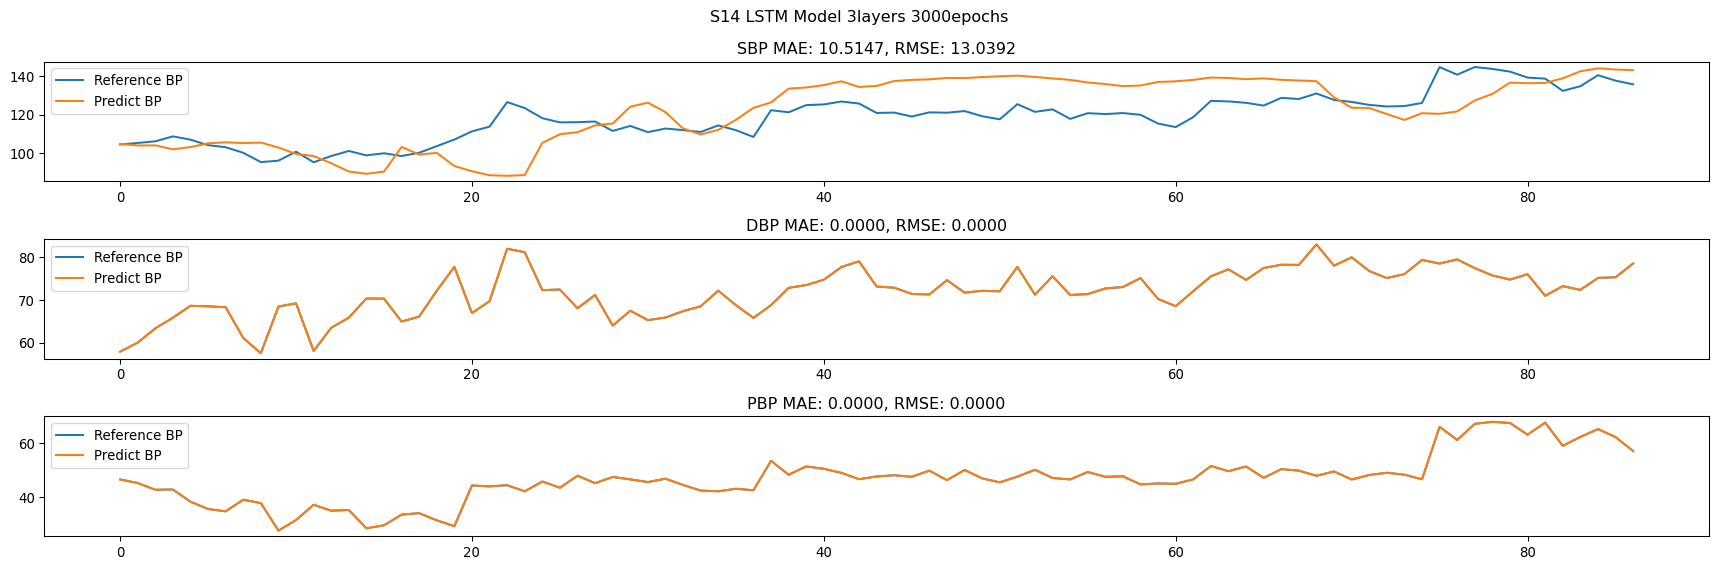

In [39]:
test_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Test_Features'
test_ft_all = list(os.walk(test_root))[0][2]

def sbp_test_lstm(ts):
    Test_Ft = pd.read_csv(f"{test_root}/{test_ft_all[ts]}")
    Test_Ftnorm = normlize_features(Test_Ft)
    X_test, y_test = reshape_data(Test_Ftnorm)
    X_test = X_test.to(device)

    y_pred = {}
    y_pred['SBP'] = sbp_lstm_model(X_test)
    y_pred['DBP'] = y_test['DBP']
    y_pred['PBP'] = y_test['PBP']
    
    results = {}
    results['BP'] = ['SBP', 'DBP', 'PBP']
    results['ref_BP'] = [y_test['SBP'][:, -1] * (max_bp - min_bp) + min_bp, y_test['DBP'][:, -1] * (max_bp - min_bp) + min_bp, y_test['PBP'][:, -1] * (max_bp - min_bp)]
    results['pred_BP'] = [(y_pred['SBP'][:, -1] * (max_bp - min_bp) + min_bp).cpu(), (y_pred['DBP'][:, -1] * (max_bp - min_bp) + min_bp).cpu(), (y_pred['PBP'][:, -1] * (max_bp - min_bp)).cpu()]
    results['MAE'] = ["{:.4f}".format(torch.mean(torch.abs(results['ref_BP'][i] - results['pred_BP'][i])).item()) for i in range(3)]
    results['RMSE'] = ["{:.4f}".format(torch.sqrt(torch.mean((results['ref_BP'][i] - results['pred_BP'][i]) ** 2)).item()) for i in range(3)]

    ## Compare BPs
    #if float(results["MAE"][0]) <= 7 or float(results["MAE"][1])<=3:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18, 6), dpi=96)
    for i in range(3):
        axs[i].plot(results['ref_BP'][i], label='Reference BP')
        axs[i].plot(results['pred_BP'][i].cpu().detach().numpy(), label='Predict BP')
        axs[i].set_title(f'{results["BP"][i]} MAE: {results["MAE"][i]}, RMSE: {results["RMSE"][i]}')
        axs[i].legend()
    fig.suptitle(f"{test_ft_all[0].split('_')[ts]} LSTM Model")
    plt.tight_layout()
    #plt.savefig(f'{result_path}/S1_LSTM_{layers}layers_{num_epochs}epochs.png', format='png')
    plt.show()
    return 

for test in range(len(test_ft_all )):
    sbp_test_lstm(test)